# Critical Role Topic Modeling Attempt 2

Last attempt we found ways to improve the model through some google searching. At the end of the last attempt I stated what I wanted to try. I said:
"I would say that there needs to be a lot more cleaning... Topic 0 and 9 are a great example. I also want to encorperate bigram and trigrams into the model."

I also want to add more to this attempt:
- Cleaning
    - Removing Actor/Actresss' Names
    - More rigorous cleaning of stop words
- Encorperate bigram and trigrams in the model
- Try different Coherence Scores

## Import Libraries

In [ ]:
!pip install pyLDAvis==3.3.1

     |████████████████████████████████| 1.7 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=fabdcef029fba518995bb098869d89b8c3bda20ced33c55bd42f2489506870d8
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
!pip install ipywidgets

In [ ]:
!pip install pandarallel==1.4.8

  Created wheel for pandarallel: filename=pandarallel-1.4.8-py3-none-any.whl size=16111 sha256=2834cf7bd5c01a03010f0f29d95781448152444371e124492ba95d117cbfa675
  Stored in directory: /root/.cache/pip/wheels/c7/f2/4e/e40c8b9344cccf6b8a02d8d8808ba837e72b607c4be946878a
Successfully built pandarallel


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 85.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=6cb1c938e0c92280f4dacaca0c3e26e778a34ec655d9cde57ddfafee03835c1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqvd479a/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['matt','roll','sam','marisha','laura','travis','talesin','ashley','liam','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading in data, cleaning, tokenizing


### Load

In [ ]:
text = open('/content/CR3-16.txt', 'r',encoding = "ISO-8859-1").read()

### Clean

I am probably going to have two cleaning functions. One is going to clean the entire episode. The second will as best as possible only pull lines of the characters and Matt.

Second: Clean the data of the parts of the episode where there is only character and DM's dialog.

In [ ]:
def cr_dialog_cleaner(episode):
    """
    Clean the data of the entire episode and create a dataframe of the spoken
    lines in the episode. 

    This includes intro, break, outro, character dialog, etc.
    
    Parameters
    ----------
    episode: A large string containing everything spoken during the episode

    Returns
    -------
    lines: A dataframe where every entry is dialog spoken during the episode
    """

    # How to locate where the dialog starts and stops
    ending_intro = "And welcome back."
    starting_break = "And we'll pick up from there after our break."
    starting_outro = "We'll pick up on that next week."
    parts = episode.split(ending_intro)
    first_part = parts[1].split(starting_break)[0]
    second_part = parts[-1].split(starting_outro)[0]
    full_dialog= first_part + "/n" + second_part

    # regex
    remove = string.punctuation
    remove = remove.replace("#", "") # don't remove hyphens
    removing_punctuation = r"[{}]".format(remove)
    non_alpha = '[^a-zA-Z#]'
    spaces = '[^\S ]+'
    multi_white_spaces = "[ ]{2,}"

    full_dialog = re.sub(removing_punctuation, "", full_dialog)
    full_dialog = re.sub(non_alpha, " ", full_dialog)
    full_dialog = re.sub(spaces, '', full_dialog)
    full_dialog = re.sub(multi_white_spaces, " ", full_dialog)
    return pd.DataFrame(full_dialog.lower().split(" # "),columns=['lines'])

In [ ]:
full_dialog_df = cr_dialog_cleaner(text)

In [ ]:
full_dialog_df.head()

,lines
0,so last we left off hells bells bells hells i...
1,sam yes you should
2,matt the other way around brain thank you
3,liam first was exclamation then you said their...
4,matt indeed i was just excited and then presen...


### Tokenizing data for LDA

In [ ]:
# identify how many processors your machine has - save the result to `n_processors`
import multiprocessing

n_processors = multiprocessing.cpu_count()
# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=nb_workers)
# so that the progress bars will work
from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

Build the bigram and trigram models

In [ ]:
bigram = gensim.models.Phrases(full_dialog_df['lines'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[full_dialog_df['lines']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [ ]:
# create our tokens in the form of lemmas 
full_dialog_df['lemmas'] = process_words(full_dialog_df['lines'])

In [ ]:
# Create lemma dictionary using Dictionary - save result to `id2word`
id2word = corpora.Dictionary(full_dialog_df['lemmas'])

# Create Term Document Frequency list - save result to `corpus`
# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in full_dialog_df['lemmas']]

## LDA Topic Modeling


### Baseline

In [ ]:
lda_model_base = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_base, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -13.880612468492473


### Attempt 1

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, coherence, limit, start=2, step=3,):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time 
start=2; limit=25;  step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=full_dialog_df['lemmas'], coherence='c_v', limit=limit, start=start, step=step)

CPU times: user 42.6 s, sys: 6.17 s, total: 48.8 s
Wall time: 48.8 s


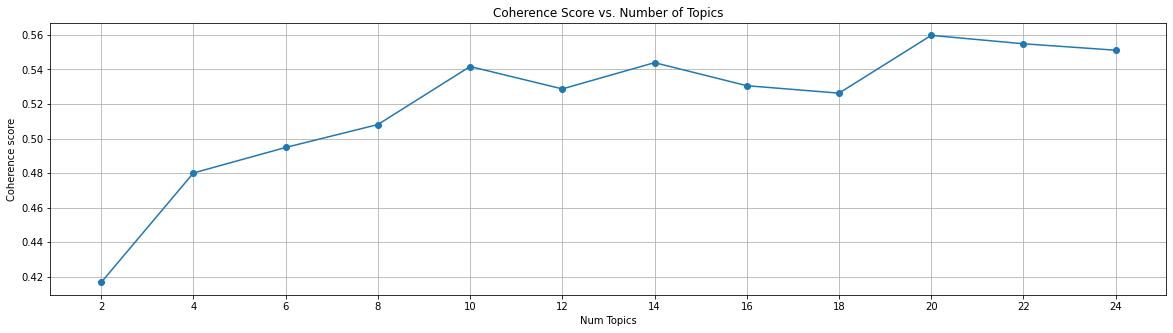

In [ ]:
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [ ]:
%%time 
start=2; limit=10;  step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=full_dialog_df['lemmas'], coherence='u_mass', limit=limit, start=start, step=step)

CPU times: user 23.3 s, sys: 3.08 s, total: 26.4 s
Wall time: 25.1 s


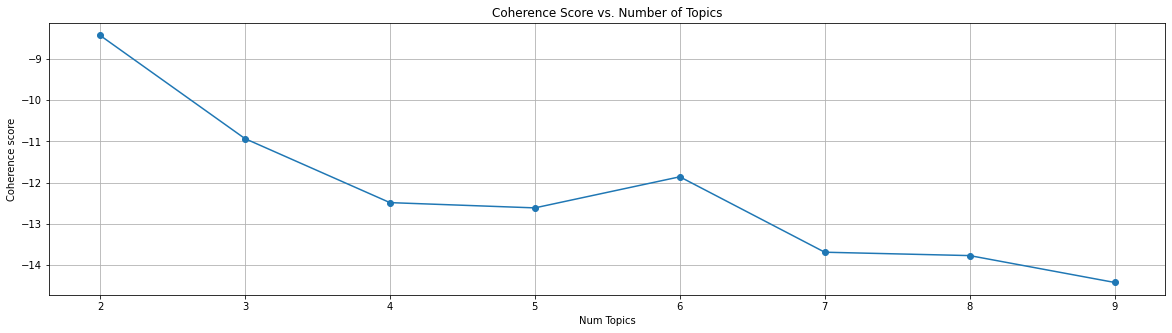

In [ ]:
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [ ]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`
max_coherence_val_index = np.argmax(coherence_values)
# use `max_coherence_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`
lda_model_1 = model_list[max_coherence_val_index]

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model_1, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.557853816881471


In [ ]:
lda_model_1.print_topics()

[(3,
  '0.103*"let" + 0.084*"well" + 0.048*"call" + 0.040*"end" + 0.039*"enough" + 0.036*"start" + 0.030*"hurt" + 0.030*"learn" + 0.028*"familiar" + 0.024*"slowly"'),
 (13,
  '0.063*"fine" + 0.034*"dexterity" + 0.027*"action" + 0.024*"weird" + 0.023*"yet" + 0.022*"flame" + 0.021*"love" + 0.019*"cut" + 0.019*"bonus" + 0.018*"dead"'),
 (5,
  '0.161*"little" + 0.078*"leave" + 0.056*"much" + 0.054*"move" + 0.027*"howl" + 0.022*"still" + 0.020*"place" + 0.020*"catch" + 0.019*"carve" + 0.019*"add"'),
 (18,
  '0.194*"feel" + 0.110*"ill" + 0.085*"laugh" + 0.054*"happen" + 0.051*"find" + 0.048*"wait" + 0.035*"strength" + 0.025*"sorry" + 0.022*"never" + 0.021*"hole"'),
 (2,
  '0.085*"foot" + 0.072*"else" + 0.053*"fuck" + 0.050*"away" + 0.034*"walk" + 0.028*"arm" + 0.027*"bring" + 0.027*"climb" + 0.025*"pick" + 0.025*"ask"'),
 (14,
  '0.124*"thing" + 0.099*"way" + 0.059*"natural" + 0.043*"work" + 0.028*"stay" + 0.026*"later" + 0.026*"okay" + 0.026*"long" + 0.022*"first" + 0.021*"wrong"'),
 (12,
 

In [ ]:
# plot your topics here -- using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_1, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.245844 -0.069744       1        1  6.618632
0     -0.233460  0.119052       2        1  6.232793
8      0.046712 -0.074813       3        1  5.790083
11     0.115062  0.105434       4        1  5.253139
13     0.045903 -0.021844       5        1  5.031408
23     0.102571  0.023655       6        1  4.702785
5     -0.080419 -0.114016       7        1  4.371281
7     -0.020909 -0.117755       8        1  4.211955
19    -0.000952 -0.033589       9        1  4.187542
17    -0.101004  0.185804      10        1  3.970203
3      0.036980  0.004176      11        1  3.923716
20     0.053354 -0.034695      12        1  3.874449
2      0.028092  0.021406      13        1  3.859708
12    -0.005005  0.198243      14        1  3.845710
15     0.010621 -0.086491      15        1  3.787169
1      0.024955  0.003521      16        1  3.649658
18     0.105086  0.013117      17        1  3.635998
14     0.030421  0.000174      18        1  3.579278
6      0.021222  0.042157      19        1  3.473170
21     0.060056  0.055321      20        1  3.301998
4      0.006444 -0.121747      21        1  3.230728
22     0.016119 -0.022650      22        1  3.193270
10    -0.084111 -0.073889      23        1  3.160285
16     0.068106 -0.000827      24        1  3.115041, topic_info=          Term       Freq      Total Category  logprob  loglift
307   laughter  98.000000  98.000000  Default  30.0000  30.0000
569       roll  92.000000  92.000000  Default  29.0000  29.0000
613       feel  77.000000  77.000000  Default  28.0000  28.0000
536        hit  77.000000  77.000000  Default  27.0000  27.0000
254     little  86.000000  86.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
1660      bone   2.487481   3.288618  Topic24  -4.9086   3.1897
1348    mainly   2.414055   3.215193  Topic24  -4.9385   3.1823
878        hum   2.397043   3.198180  Topic24  -4.9456   3.1806
1506  bullshit   2.363941   3.165078  Topic24  -4.9595   3.1771
936    scratch   4.702191   6.645115  Topic24  -4.2718   3.1231

[845 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
468       9  0.908463   ability
752      12  0.887376      able
2236     20  0.661731  absolute
1560     21  0.769096        ac
2010      2  0.918048   achieve
...     ...       ...       ...
400      10  0.903043      wrap
1632     18  0.903788     wrong
565      15  0.790863      year
732       8  0.892454      yell
872       5  0.918757       yet

[866 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 9, 12, 14, 24, 6, 8, 20, 18, 4, 21, 3, 13, 16, 2, 19, 15, 7, 22, 5, 23, 11, 17])

### Attempt 2 
I am not a big fan of 1 and 10 overlapping as much as they do, so did some research into tuning the model better than how it is currently.

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           workers=2)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics=2
max_topics=11
step_size=1
topics_range=range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01,1,0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01,1,0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=500)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


 11%|█         | 56/500 [22:52<3:01:23, 24.51s/it]

100%|██████████| 500/500 [24:30<00:00,  3.17s/it]
501it [24:33,  3.02s/it]                         
502it [24:36,  3.05s/it]
503it [24:39,  3.16s/it]
504it [24:43,  3.36s/it]
505it [24:46,  3.25s/it]
506it [24:49,  3.08s/it]
507it [24:52,  3.14s/it]
508it [24:55,  3.23s/it]
509it [24:59,  3.38s/it]
510it [25:02,  3.23s/it]
511it [25:05,  3.09s/it]
512it [25:08,  3.15s/it]
513it [25:12,  3.32s/it]
514it [25:16,  3.51s/it]
515it [25:19,  3.38s/it]
516it [25:22,  3.20s/it]
517it [25:25,  3.29s/it]
518it [25:29,  3.45s/it]
519it [25:33,  3.71s/it]
520it [25:36,  3.53s/it]
521it [25:39,  3.34s/it]
522it [25:43,  3.33s/it]
523it [25:46,  3.39s/it]
524it [25:50,  3.49s/it]
525it [25:53,  3.31s/it]
526it [25:56,  3.16s/it]
527it [25:59,  3.17s/it]
528it [26:02,  3.24s/it]
529it [26:06,  3.29s/it]
530it [26:08,  3.14s/it]
531it [26:11,  3.03s/it]
532it [26:15,  3.15s/it]
533it [26:18,  3.26s/it]
534it [26:22,  3.44s/it]
535it [26:25,  3.30s/i

In [ ]:
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9099,
                                           eta=0.61)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -8.74557341002704


In [ ]:
lda_model_2.print_topics()

[(0,
  '0.015*"little" + 0.010*"pull" + 0.010*"back" + 0.010*"bit" + 0.010*"room" + 0.009*"begin" + 0.009*"stone" + 0.009*"foot" + 0.008*"rest" + 0.008*"look"'),
 (1,
  '0.025*"laughter" + 0.019*"point" + 0.016*"feel" + 0.015*"damage" + 0.012*"ill" + 0.012*"let" + 0.011*"look" + 0.010*"time" + 0.010*"check" + 0.010*"laugh"'),
 (2,
  '0.023*"hit" + 0.017*"really" + 0.017*"thing" + 0.013*"way" + 0.013*"turn" + 0.013*"shade" + 0.012*"still" + 0.011*"great" + 0.011*"pretty" + 0.011*"throw"')]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.075517  0.135857       1        1  42.248502
2     -0.095681 -0.125592       2        1  28.909992
1      0.171197 -0.010265       3        1  28.841506, topic_info=         Term       Freq      Total Category  logprob  loglift
307  laughter  78.000000  78.000000  Default  30.0000  30.0000
536       hit  72.000000  72.000000  Default  29.0000  29.0000
466    really  53.000000  53.000000  Default  28.0000  28.0000
365     point  62.000000  62.000000  Default  27.0000  27.0000
232     thing  53.000000  53.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
127      look  34.486755  70.749887   Topic3  -4.4927   0.5248
396      much  17.269608  22.845122   Topic3  -5.1843   0.9636
356     leave  18.299170  26.316380   Topic3  -5.1264   0.8800
136      mean  18.149440  39.414771   Topic3  -5.1346   0.4679
106      help  15.145275  20.535803   Topic3  -5.3156   0.9389

[155 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
868       1  0.052537  action
868       2  0.945662  action
961       1  0.101176     add
961       2  0.101176     add
961       3  0.910583     add
...     ...       ...     ...
378       2  0.030347    well
378       3  0.819360    well
371       1  0.067645    work
371       2  0.067645    work
371       3  0.947026    work

[316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Visualing topics better!

In [ ]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=full_dialog_df['lemmas']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_2, corpus=corpus, texts=full_dialog_df['lemmas'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.968282,"little, pull, back, bit, room, begin, stone, foot, rest, look","[indeed, excite, bell, barely, escape, chaos, top, center, core, return, friend, brother, curren..."
1,1.0,0.913681,"laughter, point, feel, damage, ill, let, look, time, check, laugh","[never, understand, people, feel, bind, leave, place, confine, guess, okay, walk, city, foot, le..."
2,2.0,0.877754,"hit, really, thing, way, turn, shade, still, great, pretty, throw","[pretty, big, fight, thing, big, fight, sure, detached, ass, fart, shade, creeper, thing]"


# Topic 0
MATT 

Recapping what happened last week

# Topic 1
MARISHA

I never understood that.  
People who felt bound to not leave the places that they were confined to.  
I don't know. I guess I seemed to do it okay.  
I just walked out of the city.  
You have two feet, two legs, whatever.  
You've got means to leave.  
It's a little strange, I think, that people put so much value in feeling like if they walk out of the city limits that certain doom will encroach them.  
From my experience, sometimes staying put ensures certain doom far more than leaving.  

# Topic 2
TRAVIS

Just so we have it all out there: Lady Emoth was a pretty big fight.  
The thing behind her, going to be an even bigger fight.  
I'm sure the detached ass is going to fart out some shade creepers.  
So it's going to be a thing. 

# Final Thoughts
I like the topics the model created, but I don't like that big names like Lady Emoth got filtered out in the cleaning process. I need to look into that.

I like being able to visualize by finding a sentence that can represent the topic. I still also want a better way to visualize when these topics occur in the episode. 